<a href="https://colab.research.google.com/github/bbandbass/Study/blob/main/chp_5_%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN
지금까지 살펴본 신경망은 Feed Forward Neural Network(FFNN)이었다. FFNN은 구조가 단순하여 이해하기 쉽고 많은 문제에 응용할 수 있지만, 시계열 데이터를 잘 다루지 못한다는 단점이 있다. 그래서 순환신경망(RNN)이 등장하게 된다. 

## BPTT(Backpropagation Through Time)
시간 방향으로 펼쳐진 신경망의 오차 역전파법  
시계열 데이터의 시간 크기가 커지는 것에 비례하여 BPTT가 소비하는 컴퓨팅 자원이 증가한다는 문제가 있고, 시간 크기가 커짐에 따라 역전파 시의 기울기가 불안정해지는 것 또한 문제이다.
  

## Truncated BPTT
위와 같은 문제 때문에 시간 축 방향으로 너무 길어진 신경망을 적당한 지점에서 잘라 작은 신경망 여러 개로 나누어 작은 신경망마다 backpropagation을 수행하는 기법  
*역전파의 연결만 끊는 것이지 순전파의 연결은 끊는 것이 아니라는 것에 주의하자*
  
지금까지는 mini batch 학습 시 데이터의 순서에 대해서 크게 신경쓰지 않았지만, 지금은 시계열 데이터를 다루기 때문에 미니배치 학습을 수행할 때 구체적인 방식을 고려하여 데이터의 시작 위치를 각 미니배치의 시작 위치로 옮겨주어야 한다.    

예를 들어 길이가 1000인 시계열 데이터에 대해서 mini batch의 수를 2개로 구성해 학습을 진행한다면, 첫번째 mini batch는 순서대로 데이터를 제공하지만 두번째 mini batch는 500번째 데이터를 시작 위치로 정하고, 그 위치부터 다시 순서대로 데이터를 제공해야만 한다.(즉, 시작 위치를 500만큼 옮겨준다)

## RNN 구현
* Time RNN 계층: 순환 구조를 전부 펼친 이후의 계층들을 하나의 계층으로 간주하여 T개 단계분의 작업을 한꺼번에 처리하는 계층
* RNN 계층 - Time RNN 계층 내부에서 한 단계 작업을 수행하는 계층(한 단계를 처리하는 RNN)

### RNN 계층 구현

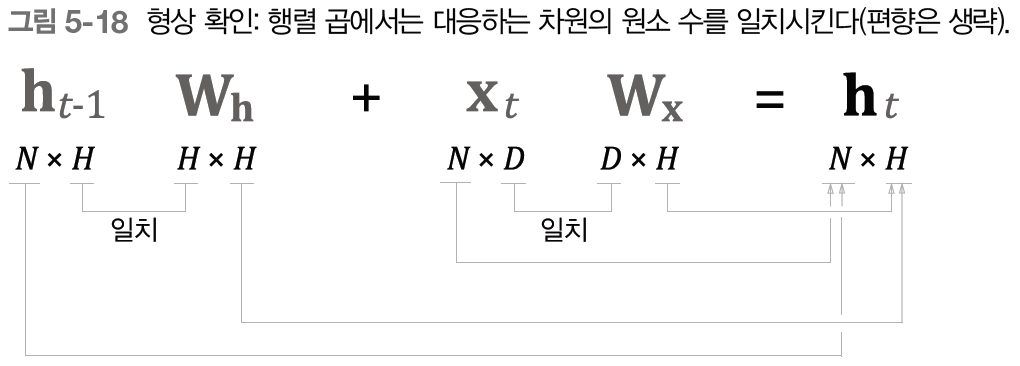

In [2]:
import numpy as np

In [3]:
# N = # of minibatches
# D = dimension of input vectors
# H = dimension of hidden state vectors

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None # 역전파 계산 시의 사용하는 중간 데이터를 담는 용도

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    h_next = np.tanh(t)

    self.cache(x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1- h_next ** 2) # tanhx의 미분은 1-tanhx^2
    db = np.sum(dt, axis = 0)
    dWh = np.matmul(h_prev.T, dt)
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)

    self.grads[0][...] = dWx # 깊은 복사
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

### TimeRNN 계층 구현
TimeRNN 계층은 RNN계층을 T개 연결한 신경망이다. 따라서 RNN 계층의 은닉 상태를 인계 받아야하는데, 이를 위해 RNN 계층 상태의 hidden state **h**를 인스턴스 변수로 유지한다.   

RNN계층의 hidden state를 TimeRNN 계층에서 관리하기로 한다. 이렇게 하면 TimeRNN 사용자는 RNN 계층 사이에서 hidden state를 인계하는 작업을 생각하지 않아도 된다는 장점이 생긴다. 이 기능을 stateful이라는 인수로 조정할 수 있도록 한다.
  
역전파 시, 출력 쪽에서 오는 gradient를 dhs로, 하류로 내보내는 gradient를 dxs로 표현한다. 여기에서 우리는 truncated BBTT를 수행하기 때문에 이 블록의 이전 시각 backpropagation은 필요하지 않다. 단, 이전 시각의 hidden state의 gradient는 인스턴스 변수 dh에 저장하도록 한다.(7장에서 다루는 seq2seq에서 사용하기 위함이라함) 

In [6]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful = False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None # 다수의 RNN게층을 리스트로 저장하는 용도

    self.h, self.dh = None, None 
    # h는 forward()를 불렀을 때의 마지막 RNN계층의 은닉 상태를 저장
    # dh는 backward()를 불렀을 때의 하나 앞 블록의 은닉 상태의 기울기를 저장
    self.stateful = stateful 
    # TimeRNN계층이 hidden state를 유지한다, 즉 아무리 긴 시계열 데이터일지라도
    # TimeRNN계층의 순전파를 끊지 않고 모두 전파한다는 의미
    # 한편, stateful = False일 때의 TimeRNN은 hidden state를 모두 
    # 0행렬으로 초기화한다.

  def set_state(self, h):
    self.h = h
  
  def reset_state(self):
    self.h = None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape # 미니배치 수, timestep 수, input vector dimension
    # xs는 T개 분량의 시계열 데이터를 하나로 모은 것
    D, H = Wx.shape # input_vector dim x hidden_state dim

    self.layers = []
    hs = np.empty((N, T, H), dtype = 'f')
    # hs는 문장에서 출력값을 담을 그릇(hs)

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype = 'f')
    # 첫 호출 시(self.h = None일 때) 원소가 모두 0인 영행렬로 초기화
    # stateful = False일 때도 항상 영행렬로 초기화

    for t in range(T): # T회 반복하는 for문을 통해 RNN 계층 생성
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h) 
      #각 timestep에서의 x와 이전 hidden state 이용해서 다음 hidden state 계산
      hs[:, t, :] = self.h # 각 timestep에 self.h 저장
      self.layers.append(layer)

    return hs
 
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, D = dhs.shape # 미니배치 수, timestep 수, input vector dimension
    # xs는 T개 분량의 시계열 데이터를 하나로 모은 것
    D, H = Wx.shape # input_vector dim x hidden_state dim

    dxs = np.empty((N, T, D), dtype = 'f')
    # 하류로 흘러보낼 기울기를 담을 그릇 dxs 만들기
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)): # T-1에서부터 0까지 거꾸로
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)
      # t번째 RNN계층에서는 위로부터(출력층)의 기울기 dh_t와, 다음 계층(h_t+1)으로부터의 기울기 d_h+1가
      # 전해진다. 이는 순전파 연산 시의 분기(2개로 repeat) 연산이 있었기 때문인데, 따라서 역전파 계산 시에는 
      # 두 기울기가 합쳐저 (dh_t + dh_{t+1})이 되게 된다.
      dxs[:, t, :] = dx

      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh

    return dxs

## 시계열 데이터 처리 계층 구현

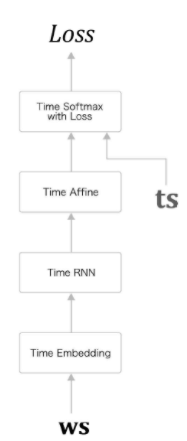

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import sys 
sys.path.append('..')
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
from common.time_layers import *

class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # Weight Initialization
    embed_W = (rn(V, D) / 100).astype('f')
    rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
    rnn_b = np.zeros(H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
        TimeEmbedding(embed_W),
        TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
        TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]

    # 모든 weight와 gradient를 리스트에 모은다
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
    
  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts) # ts는 정답
    return loss 

  def backward(self, dout = 1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout) 
    return dout

  def reset_state(self):
    self.rnn_layer.reset_state()

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common


언어 모델의 예측 성능을 평가하는 척도인 perplexity  
  
Perplexity는 간단히 말해 확률의 역수로 작을 수록 좋다.(확률이 클 수록 perplexity가 작아짐)  
Perplexity에 대한 해석은 직관적으로 다음에 취할 수 있는 선택사항의 수, 즉 다음에 출현할 수 있는 단어의 후보 수이다. 즉, perplexity가 작다는 건 다음에 출현할 수 있는 단어의 후보 수가 적다는 것으로, 다음에 출현할 수 있는 단어의 후보수를 잘 좁혔다는 의미가 된다. 반면 나쁜 모델에서는 후보수가 많다는 것을 의미한다.  

## RNNLM의 학습 코드 

In [16]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
from common.optimizer import SGD
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/dataset
from dataset import ptb

# hyperparameter
batch_size = 10
wordvec_size = 100
hidden_size = 100 # rnn의 hidden_state vector의 원소 수
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1) # corpus의 제일 큰 수가 4이면 0, 1, 2, 3, 4 5개

xs = corpus[:-1] # 입력(마지막 하나 빼고)
ts = corpus[1:] # 정답 레이블(첫번째꺼 하나 빼고)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 mini batch에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size # 얼만큼씩 건너뛸지 
offsets = [i * jump for i in range(batch_size)] # 시작 위치

for epoch in range(max_epoch):
  for iter in range(max_iters):
    # 미니배치 획득
    batch_x = np.empty((batch_size, time_size), dtype = 'i') # dtype = int32
    batch_t = np.empty((batch_size, time_size), dtype = 'i') # dtype = int32
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
      time_idx += 1

    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    total_loss += loss
    loss_count += 1

  # epoch마다 perplexity 평가
  ppl = np.exp(total_loss / loss_count)
  print('| 에폭 %d | perplexity %.2f'
        % (epoch + 1, ppl))
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0, 0

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/dataset
말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | perplexity 393.56
| 에폭 2 | perplexity 266.42
| 에폭 3 | perplexity 228.71
| 에폭 4 | perplexity 217.55
| 에폭 5 | perplexity 207.71
| 에폭 6 | perplexity 203.80
| 에폭 7 | perplexity 199.99
| 에폭 8 | perplexity 197.45
| 에폭 9 | perplexity 191.45
| 에폭 10 | perplexity 191.95
| 에폭 11 | perplexity 189.12
| 에폭 12 | perplexity 192.39
| 에폭 13 | perplexity 190.10
| 에폭 14 | perplexity 189.69
| 에폭 15 | perplexity 188.54
| 에폭 16 | perplexity 185.72
| 에폭 17 | perplexity 183.30
| 에폭 18 | perplexity 179.97
| 에폭 19 | perplexity 180.11
| 에폭 20 | perplexity 180.99
| 에폭 21 | perplexity 179.11
| 에폭 22 | perplexity 174.47
| 에폭 23 | perplexity 171.12
| 에폭 24 | perplexity 171.90
| 에폭 25 | perplexity 170.54
| 에폭 26 | perplexity 169.66
| 에폭 27 | perplexity 163.80
| 에폭 28 | perplexity 161.13
| 에폭 29 | perplexity 157.30
| 에폭 30 | perplexity 151.10
| 에폭 31 | perple

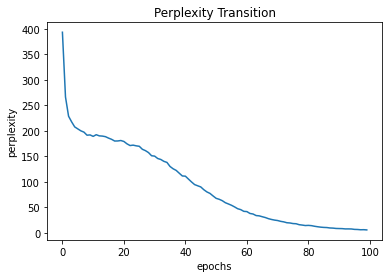

In [20]:
plt.plot(ppl_list)
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.title('Perplexity Transition')
plt.show()

RNNLM의 Tranier 클래스를 이용한 학습

/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
/content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/dataset
| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.72
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 395.78
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 269.71
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 223.38
| 에폭 5 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 211.43
| 에폭 6 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 209.68
| 에폭 7 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 201.78
| 에폭 8 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 200.75
| 에폭 9 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 195.17
| 에폭 10 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 190.88
| 에폭 11 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 192.63
| 에폭 12 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 189.16
| 에폭 13 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 192.21
| 에폭 14 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 186.09
| 에폭 15 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 186.19
| 에폭 16 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 190.72
| 에폭 17 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 188.17
| 에폭 18 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 183.32
| 에폭 19 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 180.29
| 에폭 2

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


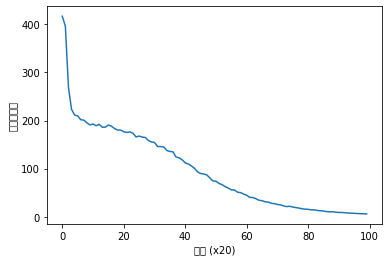

In [21]:
# coding: utf-8
import sys
sys.path.append('..')

%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/common
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
%cd /content/drive/MyDrive/밑바닥부터 시작하는 딥러닝2/dataset
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000 # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1] # 입력
ts = corpus[1:] # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
# fit() method에서 
# 1. mini batch를 순차적으로 만들어
# 2. 모델의 forward process와 backpropagation를 호출하고
# 3. optimizer로 weights를 update하고
# 4. perplexity를 구하는 일련의 과정이 수행된다. 
trainer.plot()